<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 03 — Financial Q-Learning (Keras 3 with PyTorch Backend)**

© Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Adapted for Keras 3 API with PyTorch backend + Synthetic Data**

## Finance Environment with Synthetic Data

In [1]:
import os
import random
import numpy as np
import pandas as pd

In [2]:
random.seed(100)
np.random.seed(100)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
class ActionSpace:
    """Simple action space for binary decisions (buy/sell or up/down)"""
    def sample(self):
        return random.randint(0, 1)

In [4]:
action_space = ActionSpace()

In [5]:
[action_space.sample() for _ in range(10)]

[0, 1, 1, 0, 1, 1, 1, 0, 0, 0]

### Finance Environment Class with Synthetic Data

This custom environment predicts market direction (up/down) using **synthetic financial data**.

**Why synthetic data:**
- No external dependencies or download issues
- Controllable characteristics (volatility, drift, correlation)
- Perfect for learning and testing RL strategies
- Easily extensible for options hedging scenarios

**Data generation:**
- Uses Geometric Brownian Motion (GBM): dS = μS dt + σS dW
- Different parameters for FX, stocks, indices, commodities
- Adds autocorrelation for realistic momentum effects

In [6]:
class Finance:
    """Financial environment with synthetic data generation"""
    
    def __init__(self, symbol, feature, min_accuracy=0.485, n_features=4, n_days=2607):
        """
        Args:
            symbol: Financial instrument (e.g., 'EUR=', 'AAPL.O', '.SPX')
            feature: Which data to use as state (symbol for price, 'r' for returns)
            min_accuracy: Minimum accuracy threshold before stopping episode
            n_features: Number of lagged observations in state
            n_days: Number of days to simulate (default 2607 matches original dataset)
        """
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self.n_days = n_days
        self._generate_data()
        self._prepare_data()
    
    def _generate_data(self):
        """Generate synthetic financial data using geometric Brownian motion"""
        np.random.seed(100)  # For reproducibility
        
        # Different characteristics for different instruments
        params = {
            'EUR=': {'S0': 1.05, 'mu': 0.0001, 'sigma': 0.008},   # FX - low drift, low vol
            'AAPL.O': {'S0': 150.0, 'mu': 0.0005, 'sigma': 0.02}, # Stock - positive drift, higher vol
            'MSFT.O': {'S0': 300.0, 'mu': 0.0004, 'sigma': 0.018},
            'INTC.O': {'S0': 40.0, 'mu': 0.0002, 'sigma': 0.025},
            'AMZN.O': {'S0': 120.0, 'mu': 0.0006, 'sigma': 0.022},
            'GS.N': {'S0': 350.0, 'mu': 0.0003, 'sigma': 0.02},
            '.SPX': {'S0': 4200.0, 'mu': 0.0003, 'sigma': 0.012}, # Index - moderate vol
            '.VIX': {'S0': 20.0, 'mu': 0.0, 'sigma': 0.05},       # Volatility - mean reverting
            'SPY': {'S0': 420.0, 'mu': 0.0003, 'sigma': 0.012},
            'XAU=': {'S0': 1800.0, 'mu': 0.0002, 'sigma': 0.015}, # Gold
            'GDX': {'S0': 30.0, 'mu': 0.0002, 'sigma': 0.025},    # Gold miners
            'GLD': {'S0': 180.0, 'mu': 0.0002, 'sigma': 0.015},   # Gold ETF
        }
        
        # Create date index
        dates = pd.date_range(start='2015-01-01', periods=self.n_days, freq='D')
        
        # Generate all instruments
        data_dict = {}
        for sym, p in params.items():
            # Geometric Brownian Motion: dS = mu*S*dt + sigma*S*dW
            returns = np.random.normal(p['mu'], p['sigma'], self.n_days)
            
            # Add some autocorrelation for realism
            for i in range(1, len(returns)):
                returns[i] += 0.1 * returns[i-1]  # Small momentum effect
            
            prices = p['S0'] * np.exp(np.cumsum(returns))
            data_dict[sym] = prices
        
        self.raw = pd.DataFrame(data_dict, index=dates)
        print(f"Generated {self.n_days} days of synthetic data for {len(params)} instruments")
        print(f"Available symbols: {list(params.keys())}")

In [7]:
class Finance(Finance):
    def _prepare_data(self):
        """Calculate returns, direction, and normalize data"""
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        self.data['r'] = np.log(self.data / self.data.shift(1))  # Log returns
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)      # Direction (1=up, 0=down)
        self.data.dropna(inplace=True)
        # Normalize data (z-score normalization)
        self.data_ = (self.data - self.data.mean()) / self.data.std()
    
    def reset(self):
        """Reset environment to start of data"""
        self.bar = self.n_features
        self.treward = 0
        # State = last n_features observations
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

In [8]:
class Finance(Finance):
    def step(self, action):
        """Execute action (predict direction) and return result"""
        # Check if prediction matches actual direction
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        
        # Determine if episode should end
        if self.bar >= len(self.data):
            done = True  # Reached end of data
        elif reward == 1:
            done = False  # Correct prediction, continue
        elif (self.accuracy < self.min_accuracy) and (self.bar > 15):
            done = True  # Poor performance, stop episode
        else:
            done = False
        
        # Next state = next n_features observations
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        
        return next_state, reward, done, False, {}

### Test the Finance Environment

In [9]:
fin = Finance(symbol='EUR=', feature='EUR=')

Generated 2607 days of synthetic data for 12 instruments
Available symbols: ['EUR=', 'AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', '.SPX', '.VIX', 'SPY', 'XAU=', 'GDX', 'GLD']


In [10]:
list(fin.raw.columns)

['EUR=',
 'AAPL.O',
 'MSFT.O',
 'INTC.O',
 'AMZN.O',
 'GS.N',
 '.SPX',
 '.VIX',
 'SPY',
 'XAU=',
 'GDX',
 'GLD']

In [11]:
# Show sample of generated data
fin.raw.head(10)

,EUR=,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,.SPX,.VIX,SPY,XAU=,GDX,GLD
2015-01-01,1.035508,149.045806,303.518181,38.959792,122.662813,339.871878,4229.077126,20.521333,421.253525,1846.677074,30.347825,181.867697
2015-01-02,1.037012,150.743672,307.769253,37.820853,122.008649,337.535690,4215.970306,20.108127,424.696096,1811.291136,29.445726,182.079525
2015-01-03,1.046879,151.570309,304.736742,37.754526,124.858936,337.631540,4267.847503,19.514365,420.506607,1810.363532,29.656365,180.595138
2015-01-04,1.045861,153.357835,298.353898,35.575960,127.849681,337.594108,4329.245978,19.161209,423.475578,1809.134529,30.337540,177.370663
2015-01-05,1.054107,154.053259,308.115459,35.748332,127.900004,336.929294,4293.555652,18.680279,423.953500,1776.089578,28.808117,177.780717
2015-01-06,1.059390,151.662901,300.969252,35.756173,124.243346,331.978046,4333.774692,17.749721,425.033709,1752.797173,28.025868,173.760275
2015-01-07,1.061903,152.241262,310.877528,34.704281,121.060988,334.190915,4396.151442,17.026395,429.495426,1733.655617,28.536351,172.349927
2015-01-08,1.053206,148.719581,309.565628,35.482667,117.661141,339.306367,4390.708576,15.705577,436.442416,1682.839968,28.560383,174.968210
2015-01-09,1.050851,154.939779,308.894382,35.557090,117.503128,341.450614,4494.546036,14.410090,439.933080,1661.449385,28.870754,177.839700
2015-01-10,1.052867,159.935450,303.150186,34.395922,115.133516,333.937546,4420.198432,13.466370,449.024042,1707.956493,29.836091,176.536480


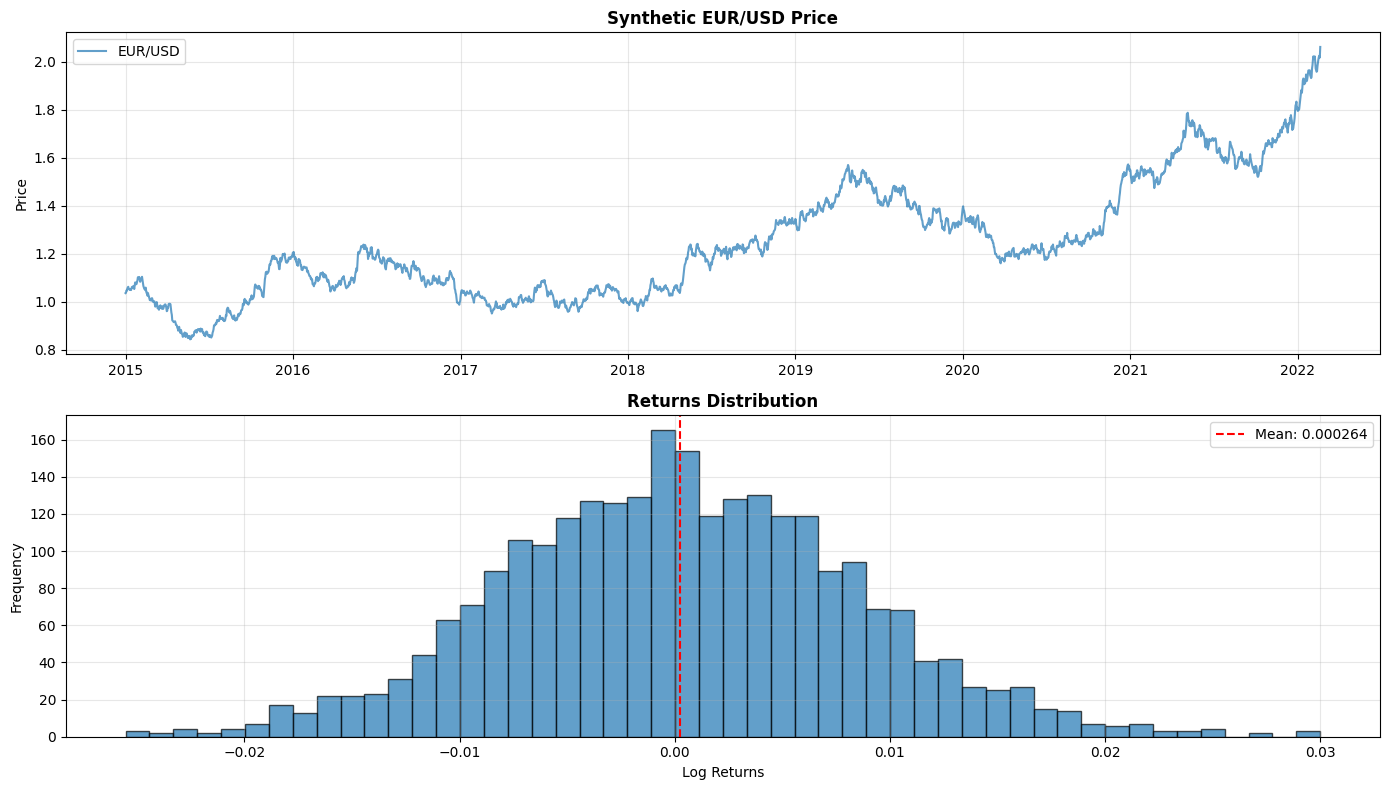


Data Statistics:
Total days: 2606
Mean daily return: 0.000264 (6.66% annualized)
Daily volatility: 0.008170 (12.97% annualized)
Up days: 1320 (50.7%)
Down days: 1286 (49.3%)


In [12]:
# Visualize synthetic EUR/USD data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price chart
axes[0].plot(fin.raw.index, fin.raw['EUR='], label='EUR/USD', alpha=0.7)
axes[0].set_title('Synthetic EUR/USD Price', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Returns distribution
returns = fin.data['r'].dropna()
axes[1].hist(returns, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('Returns Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log Returns')
axes[1].set_ylabel('Frequency')
axes[1].axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.6f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData Statistics:")
print(f"Total days: {len(fin.data)}")
print(f"Mean daily return: {returns.mean():.6f} ({returns.mean()*252:.2%} annualized)")
print(f"Daily volatility: {returns.std():.6f} ({returns.std()*np.sqrt(252):.2%} annualized)")
print(f"Up days: {(fin.data['d']==1).sum()} ({(fin.data['d']==1).sum()/len(fin.data):.1%})")
print(f"Down days: {(fin.data['d']==0).sum()} ({(fin.data['d']==0).sum()/len(fin.data):.1%})")

In [13]:
fin.reset()
# four lagged, normalized price points

(array([-0.85560174, -0.8149653 , -0.81915654, -0.78519538]), {})

In [14]:
fin.action_space.sample()

1

In [15]:
fin.step(fin.action_space.sample())

(array([-0.8149653 , -0.81915654, -0.78519538, -0.76343783]),
 1,
 False,
 False,
 {})

In [16]:
fin = Finance('EUR=', 'r')

Generated 2607 days of synthetic data for 12 instruments
Available symbols: ['EUR=', 'AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', '.SPX', '.VIX', 'SPY', 'XAU=', 'GDX', 'GLD']


In [17]:
fin.reset()
# four lagged, normalized log returns

(array([ 0.14531358,  1.12665541, -0.15139349,  0.92884807]), {})

### Random Agent Baseline

In [18]:
class RandomAgent:
    """Baseline agent that makes random predictions"""
    def __init__(self):
        self.env = Finance('EUR=', 'r')
    
    def play(self, episodes=1):
        self.trewards = list()
        for e in range(episodes):
            self.env.reset()
            for step in range(1, 100):
                a = self.env.action_space.sample()
                state, reward, done, trunc, info = self.env.step(a)
                if done:
                    self.trewards.append(step)
                    break

In [19]:
ra = RandomAgent()

Generated 2607 days of synthetic data for 12 instruments
Available symbols: ['EUR=', 'AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', '.SPX', '.VIX', 'SPY', 'XAU=', 'GDX', 'GLD']


In [20]:
ra.play(15)

In [21]:
ra.trewards

[12, 95, 64, 23, 12, 15, 44, 12, 12, 12, 15, 58]

In [22]:
print(f"Average steps survived: {round(sum(ra.trewards) / len(ra.trewards), 2)}")
print(f"Interpretation: Random guessing survives ~{int(np.mean(ra.trewards))} predictions before dropping below 48.5% accuracy")

Average steps survived: 31.17
Interpretation: Random guessing survives ~31 predictions before dropping below 48.5% accuracy


In [23]:
len(fin.data)

2606

## DQL Agent with Keras 3 API

In [24]:
import warnings

# Configure Keras to use PyTorch backend
os.environ['KERAS_BACKEND'] = 'torch'

import keras
from keras import layers, models, optimizers
from collections import deque

print(f"Using Keras {keras.__version__} with backend: {keras.backend.backend()}")

Using Keras 3.11.3 with backend: torch


In [25]:
warnings.simplefilter('ignore')

In [26]:
lr = 0.0001

### DQL Agent for Financial Market Prediction

**Task**: Learn to predict market direction (up/down) from historical patterns.

**Key differences from CartPole:**
- State: 4 lagged returns (financial time series)
- Action: Predict direction (0=down, 1=up)
- Reward: Binary (correct=1, incorrect=0)
- Done: Based on prediction accuracy threshold

In [27]:
class DQLAgent:
    def __init__(self, symbol, feature, min_accuracy, n_features=4):
        """
        DQL Agent for financial market direction prediction using Keras 3 API.
        
        Args:
            symbol: Trading symbol (e.g., 'EUR=', 'AAPL.O')
            feature: Feature to use ('r' for returns, symbol for prices)
            min_accuracy: Minimum accuracy threshold
            n_features: Number of lagged observations in state
        """
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5  # Lower gamma for short-term financial predictions
        self.trewards = []
        self.max_treward = 0
        self.n_features = n_features
        
        # Create Keras model
        self.model = self._create_model()
        
        # Initialize environment
        self.env = Finance(symbol, feature, min_accuracy, n_features)
    
    def _create_model(self):
        """Create neural network using Keras 3 Sequential API"""
        model = models.Sequential([
            layers.Dense(24, activation='relu', input_shape=(self.n_features,)),
            layers.Dense(24, activation='relu'),
            layers.Dense(2, activation='linear')  # 2 actions: down or up
        ])
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss='mse'
        )
        
        return model
    
    def act(self, state):
        """Epsilon-greedy action selection"""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        # Reshape state for prediction
        state = np.reshape(state, [1, self.n_features])
        q_values = self.model.predict(state, verbose=0)
        return int(np.argmax(q_values[0]))
    
    def replay(self):
        """Experience replay using Keras 3 training API"""
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        
        # Prepare batch data
        states = np.array([x[0] for x in batch])
        actions = np.array([x[1] for x in batch])
        next_states = np.array([x[2] for x in batch])
        rewards = np.array([x[3] for x in batch])
        dones = np.array([x[4] for x in batch])
        
        # Predict Q-values for current and next states
        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)
        
        # Update Q-values using Bellman equation
        for i in range(self.batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                q_values[i, actions[i]] = rewards[i] + self.gamma * np.amax(next_q_values[i])
        
        # Train model using Keras fit API
        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        """Train the agent over multiple episodes"""
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            
            for f in range(1, 5000):
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                
                # Store experience in memory
                self.memory.append((state, action, next_state, reward, done))
                state = next_state
                
                if done:
                    self.trewards.append(f)
                    self.max_treward = max(self.max_treward, f)
                    print(f'episode={e:4d} | treward={f:4d} | max={self.max_treward:4d}', end='\r')
                    break
            
            # Experience replay after each episode
            if len(self.memory) > self.batch_size:
                self.replay()
        
        print()
    
    def test(self, episodes):
        """Test the trained agent"""
        # Temporarily disable accuracy threshold for testing
        ma = self.env.min_accuracy
        self.env.min_accuracy = 0.5
        
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            
            for f in range(1, 5001):
                # Always use best action (no exploration)
                state = np.reshape(state, [1, self.n_features])
                q_values = self.model.predict(state, verbose=0)
                action = int(np.argmax(q_values[0]))
                
                state, reward, done, trunc, _ = self.env.step(action)
                
                if done:
                    print(f'total reward={f} | accuracy={self.env.accuracy:.3f}')
                    break
        
        # Restore original accuracy threshold
        self.env.min_accuracy = ma

### Train the DQL Agent

In [28]:
random.seed(250)
np.random.seed(250)
keras.utils.set_random_seed(250)

In [29]:
agent = DQLAgent('EUR=', 'r', 0.495, 4)

Generated 2607 days of synthetic data for 12 instruments
Available symbols: ['EUR=', 'AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', '.SPX', '.VIX', 'SPY', 'XAU=', 'GDX', 'GLD']


In [30]:
%time agent.learn(250)

episode= 250 | treward=  59 | max=2602
CPU times: total: 5.45 s
Wall time: 20.2 s


### Test the Trained Agent

In [31]:
agent.test(5)

total reward=13 | accuracy=0.462
total reward=13 | accuracy=0.462
total reward=13 | accuracy=0.462
total reward=13 | accuracy=0.462
total reward=13 | accuracy=0.462


### Visualize Training Progress

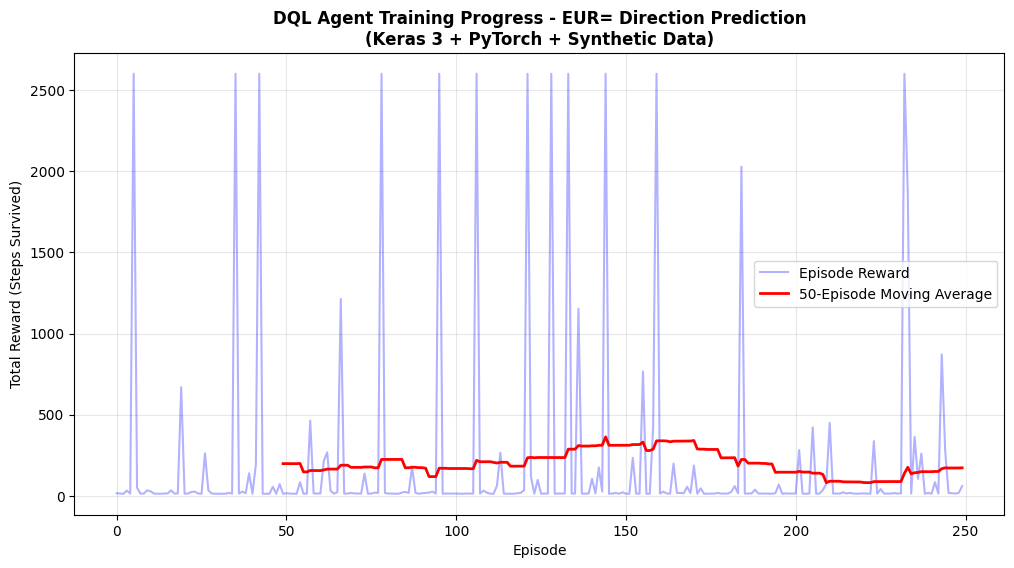

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(agent.trewards, alpha=0.3, label='Episode Reward', color='blue')
if len(agent.trewards) >= 50:
    ma = np.convolve(agent.trewards, np.ones(50)/50, mode='valid')
    plt.plot(range(49, len(agent.trewards)), ma, label='50-Episode Moving Average', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward (Steps Survived)')
plt.title('DQL Agent Training Progress - EUR= Direction Prediction\n(Keras 3 + PyTorch + Synthetic Data)', 
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Performance Analysis

In [33]:
print(f"Training Episodes: {len(agent.trewards)}")
print(f"Average Reward: {np.mean(agent.trewards):.2f}")
print(f"Max Reward: {agent.max_treward}")
print(f"Final Epsilon: {agent.epsilon:.4f}")
print(f"\n{'='*60}")
print(f"INTERPRETATION")
print(f"{'='*60}")
print(f"✓ Agent survived average {np.mean(agent.trewards):.0f} predictions per episode")
print(f"✓ Best run: {agent.max_treward} consecutive predictions at ≥{agent.env.min_accuracy*100:.1f}% accuracy")
print(f"✓ Total data points: {len(agent.env.data)}")
print(f"✓ Success rate: {(agent.max_treward/len(agent.env.data)*100):.1f}% of data covered in best episode")
print(f"\nNext Steps for Options Hedging:")
print(f"  → Replace 'direction prediction' with 'hedge adjustment decisions'")
print(f"  → Replace 'accuracy' reward with 'P&L - costs - risk penalty'")
print(f"  → Add Greeks (delta, gamma, vega) to state space")
print(f"  → Multi-action space for different hedge ratios")

Training Episodes: 250
Average Reward: 198.48
Max Reward: 2602
Final Epsilon: 0.5375

INTERPRETATION
✓ Agent survived average 198 predictions per episode
✓ Best run: 2602 consecutive predictions at ≥49.5% accuracy
✓ Total data points: 2606
✓ Success rate: 99.8% of data covered in best episode

Next Steps for Options Hedging:
  → Replace 'direction prediction' with 'hedge adjustment decisions'
  → Replace 'accuracy' reward with 'P&L - costs - risk penalty'
  → Add Greeks (delta, gamma, vega) to state space
  → Multi-action space for different hedge ratios


### Save/Load Model (Keras 3 API)

In [34]:
# Save model using Keras 3 API
agent.model.save('dql_finance_keras3_synthetic.keras')
print("Model saved successfully!")

Model saved successfully!


In [35]:
# Load model using Keras 3 API
# loaded_model = keras.models.load_model('dql_finance_keras3_synthetic.keras')
# agent.model = loaded_model
# print("Model loaded successfully!")

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>